## The Problem of Multi-Class Sentiment Analysis

Multi-class sentiment analysis refers to the task of classifying textual data into more than two sentiment categories, such as **positive**, **neutral**, and **negative**. Unlike binary sentiment analysis, which distinguishes only between positive and negative sentiments, the multi-class approach provides a more nuanced understanding of the emotional content within text.

### Why is Multi-Class Sentiment Analysis Important?

Binary sentiment classification, while useful in simple applications, suffers from significant limitations. One key drawback is its inability to account for **neutral sentiment**. Many real-world texts, especially those from social media platforms like Twitter, do not express strong opinions and instead fall into a neutral category. Ignoring this class leads to a **loss of valuable information** and may introduce bias in downstream decision-making processes.

By contrast, a multi-class sentiment analysis approach:
- Enables **richer and more accurate sentiment representation**;
- Allows for **better understanding of customer opinions** and public attitudes;
- Supports **more precise analytics** for businesses and researchers;
- Facilitates **improved decision-making** based on more granular emotional insights.

### Project Objective

The primary objective of this project is to **design and evaluate various machine learning and deep learning models** for multi-class, single-label sentiment classification using the [**Twitter US Airline Sentiment**](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data) dataset. We aim to:
- Compare the performance of traditional machine learning models (e.g., Logistic Regression, SVM) with state-of-the-art deep learning models (e.g., fine-tuned transformer-based architectures);
- Analyze the strengths and weaknesses of each model with respect to class imbalance and generalization;
- Provide recommendations for practical deployment in real-world sentiment analysis systems.


# 1. Data Selection and Preparation

Effective data selection and preprocessing are the foundation of any successful machine learning project. High-quality, well-prepared data significantly improves model performance and generalization.

## 1.1 Dataset Selection

In this project, we use the **Twitter US Airline Sentiment** dataset, which is publicly available on [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment). The dataset contains **14,640 tweets** directed at major U.S. airlines and labeled with one of three sentiment categories: **positive**, **neutral** and **negative**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/kaggle/input/twitter-airline-sentiment/Tweets.csv"
df = pd.read_csv(path, index_col=False)

In [3]:
df_processed = df[['text', 'airline_sentiment']].copy()
target_names=['Negative', 'Neutral', 'Positive']

# Mapping: negative=0, neutral=1, positive=2
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_processed['label'] = df_processed['airline_sentiment'].map(sentiment_mapping)
df_processed = df_processed[['text', 'label']]
df_processed.head()

,text,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [4]:
df_processed.shape

(14640, 2)

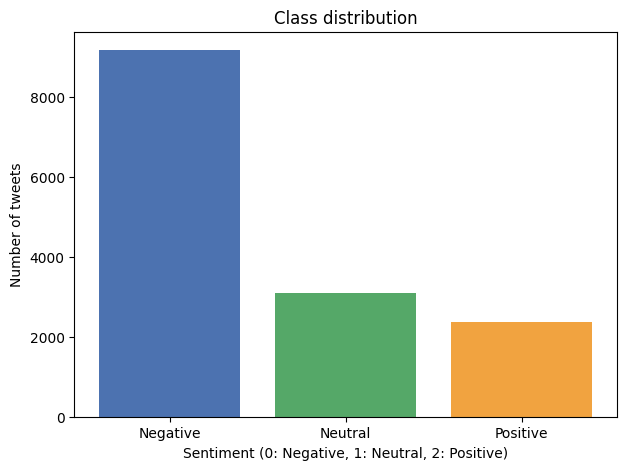

In [14]:
labels = df_processed['label'].value_counts().index
counts = df_processed['label'].value_counts().values

plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color=['#4c72b0', '#55a868', '#f1a340'])
plt.title('Class distribution')
plt.xlabel('Sentiment (0: Negative, 1: Neutral, 2: Positive)')
plt.ylabel('Number of tweets')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

plt.show()


In [20]:
# Example samples for each class
negative_samples = df_processed[df_processed['label'] == 0].sample(2, random_state=42)
neutral_samples = df_processed[df_processed['label'] == 1].sample(2, random_state=42)
positive_samples = df_processed[df_processed['label'] == 2].sample(2, random_state=42)

def print_samples(class_name, samples):
    print(f"\n--- {class_name} ---")
    print("-" * 50)
    for i, row in samples.iterrows():
        print(f"Text: {row['text']}")
        print(f"Label: {row['label']}")
        print("-" * 50)

print("Example samples for each class")
print_samples("Negative (label 0)", negative_samples)
print_samples("Neutral (label 1)", neutral_samples)
print_samples("Positive (label 2)", positive_samples)


Example samples for each class

--- Negative (label 0) ---
--------------------------------------------------
Text: @united gate C 24 IAD. U released passengers to board w/others deplaning .50 peopleOn bridge while next flight  board http://t.co/HfoF33iyhi
Label: 0
--------------------------------------------------
Text: @USAirways 1729 connecting in charlotte to houston. Mechanical issue determined while q'd to take off. And we checked our bags.
Label: 0
--------------------------------------------------

--- Neutral (label 1) ---
--------------------------------------------------
Text: @united we finally just arrive to Bogota, good but long flight!!
Label: 1
--------------------------------------------------
Text: @AmericanAir got a callback at 1 am, took care of it. thanks.
Label: 1
--------------------------------------------------

--- Positive (label 2) ---
--------------------------------------------------
Text: @SouthwestAir thanks for your excellent response time and assistanc

## 1.2 Text Preprocessing

Text preprocessing is a crucial step in any NLP pipeline. It involves cleaning and normalizing the raw textual data to reduce noise and improve the effectiveness of feature extraction and model performance.

### Preprocessing Steps

The following preprocessing steps are applied in this project:

- **Lowercasing**: Converting all text to lowercase using `text.lower()`. This helps reduce redundancy, as "Flight" and "flight" should be considered the same.
- **Removing punctuation and numbers**: Using regular expressions such as to eliminate irrelevant characters that do not contribute to sentiment analysis.
- **Removing HTML tags and URLs**: Particularly useful for datasets extracted from the web. URLs are removed using regex patterns.
- **Stopword removal**: Common words (e.g., "the", "is", "at") are typically removed to focus on content words. However, in sentiment analysis, caution must be exercised, as negations like *"not"*, *"no"*, or *"never"* carry strong sentiment. Therefore, a custom stopword list is used that retains such words.
- **Lemmatization**: Reducing words to their base form (e.g., "delayed" → "delay") using `WordNetLemmatizer`. This helps reduce dimensionality while preserving meaning.

### Preprocessing Function

Below is a reusable Python function that applies the aforementioned steps:


In [21]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

In [22]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

stop_words = set(stopwords.words('english'))
words_to_keep = {
    'not', 'no', 'nor', 'don', 'ain', 'aren', 'couldn', 'didn', 'doesn',
    'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn',
    'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'never', 'aren'
}
stop_words = stop_words - words_to_keep

lemmatizer = WordNetLemmatizer()

In [23]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Remove HTML tags and URLs
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stop words
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [24]:
df_processed['clean_text'] = df_processed['text'].apply(preprocess_text)

# 2. Baseline Models

Before applying complex neural network models, we first establish baseline performance using traditional machine learning classifiers. These models are relatively fast to train and offer valuable insights into the data and task complexity.

## 2.1 Feature Extraction

Before applying machine learning models, we need to convert the preprocessed text data into numerical format. This process is known as **feature extraction**. In this project, we consider two common approaches: TF-IDF and Bag-of-Words (BoW).

### 2.1.1 TF-IDF

The **Term Frequency–Inverse Document Frequency (TF-IDF)** method weighs the importance of a word in a document relative to its frequency in the entire corpus. This helps reduce the impact of commonly occurring but less informative words.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_processed['clean_text'])
y = df_processed['label']

### 2.1.2 Bag-of-Words (BoW)
The Bag-of-Words model is a simpler technique that represents each document as a vector of word counts. While it does not account for word importance across documents, it often performs surprisingly well on many classification problems.


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(df_processed['clean_text'])

## 2.2 Model Training and Evaluation

We will evaluate the following baseline classifiers: **Logistic Regression**, **Multinomial Naive Bayes** and **Support Vector Machine (SVM)**

Each model will be trained on TF-IDF feature representations of the preprocessed tweets. Performance will be measured using the following metrics:

- **Accuracy** – the overall proportion of correctly classified instances.
- **Precision** – the ratio of true positives to all predicted positives, computed per class.
- **Recall** – the ratio of true positives to all actual positives, computed per class.
- **F1-Score** – the harmonic mean of precision and recall, providing a balanced evaluation of both.

These metrics offer a comprehensive evaluation framework, especially useful in the presence of class imbalance. Each model is trained separately on both TF-IDF and Bag-of-Words features to assess the impact of feature representation on classification performance.



### 2.2.1 Hyperparameter Tuning with GridSearchCV

Before evaluating our models, we perform hyperparameter tuning using **GridSearchCV** with 5-fold cross-validation. This ensures that each classifier is trained with its optimal settings, improving its generalization ability and fairness in comparison.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

base_results = {}

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'max_iter': [2000],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
    },
    "Naive Bayes": {
        'alpha': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0, 2.0],
        'fit_prior': [True, False]
    },
    "SVM": {
        'C': [0.01, 0.1, 1, 10],
        'max_iter': [200000],
        'loss': ['hinge', 'squared_hinge']
    }
}

In [28]:
def evaluate_model(model, X_test, y_test, target_names):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)

    print(classification_report(y_test, y_pred, target_names=target_names))

    return {
        "Accuracy": report["accuracy"],
        "F1-Score": report["weighted avg"]["f1-score"]
    }

### 2.2.1 Training on TF-IDF Features

In this subsection, we train three baseline classifiers—**Logistic Regression**, **Multinomial Naive Bayes**, and **Support Vector Machine (SVM)**—using the TF-IDF feature representation of the tweet text.

To ensure optimal performance, we use **GridSearchCV** with 5-fold cross-validation to perform hyperparameter tuning for each model. The models are then evaluated on the held-out test set using metrics such as accuracy, precision, recall, and F1-score.

In [29]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [236]:
print(f"Train dataset lengths: {len(y_train)}")
print(f"Test dataset lengths: {len(y_test)}")

Train dataset lengths: 11712
Test dataset lengths: 2928


In [30]:
best_models_tfidf = {}

# Grid search for each model
for name, model in models.items():
    print(f"\nRunning GridSearchCV for {name}...")
    grid_tfidf = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_tfidf.fit(X_train_tfidf, y_train)
    best_models_tfidf[name] = grid_tfidf.best_estimator_
    print(f"Best parameters for {name}: {grid_tfidf.best_params_}")


Running GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}

Running GridSearchCV for Naive Bayes...
Best parameters for Naive Bayes: {'alpha': 0.1, 'fit_prior': False}

Running GridSearchCV for SVM...
Best parameters for SVM: {'C': 1, 'loss': 'hinge', 'max_iter': 200000}


In [31]:
for name, model in best_models_tfidf.items():
    print(f"\n{name} (TF-IDF):")
    metrics = evaluate_model(model, X_test_tfidf, y_test, target_names)
    base_results[f"{name} (TF-IDF)"] = metrics


Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.85      0.90      0.88      1889
     Neutral       0.64      0.55      0.59       580
    Positive       0.75      0.68      0.71       459

    accuracy                           0.80      2928
   macro avg       0.75      0.71      0.73      2928
weighted avg       0.79      0.80      0.79      2928


Naive Bayes (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.89      0.79      0.84      1889
     Neutral       0.51      0.60      0.55       580
    Positive       0.60      0.74      0.66       459

    accuracy                           0.74      2928
   macro avg       0.67      0.71      0.68      2928
weighted avg       0.77      0.74      0.75      2928


SVM (TF-IDF):
              precision    recall  f1-score   support

    Negative       0.84      0.92      0.88      1889
     Neutral       0.65      0.51      0.57       580
    Po

### 2.2.3 Evaluation on Bag-of-Words (BoW) Features

In this subsection, we repeat the same training and evaluation procedure using the **Bag-of-Words (BoW)** feature representation instead of TF-IDF.

We again apply **GridSearchCV** to optimize the hyperparameters of the baseline classifiers: **Logistic Regression**, **Multinomial Naive Bayes**, and **Support Vector Machine (SVM)**. Each model is trained on BoW-transformed features and evaluated on the same test set.

In [32]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [33]:
best_models_bow = {}

# Grid search for each model
for name, model in models.items():
    print(f"\nRunning GridSearchCV for {name} (BoW)...")
    grid_bow = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_bow.fit(X_train_bow, y_train)
    best_models_bow[name] = grid_bow.best_estimator_
    print(f"Best parameters for {name} (BoW): {grid_bow.best_params_}")


Running GridSearchCV for Logistic Regression (BoW)...
Best parameters for Logistic Regression (BoW): {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}

Running GridSearchCV for Naive Bayes (BoW)...
Best parameters for Naive Bayes (BoW): {'alpha': 0.7, 'fit_prior': True}

Running GridSearchCV for SVM (BoW)...
Best parameters for SVM (BoW): {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 200000}


In [34]:
# Evaluate best models on BoW test set
for name, model in best_models_bow.items():
    print(f"\n{name} (BoW Features):")
    metrics = evaluate_model(model, X_test_bow, y_test, target_names)
    base_results[f"{name} (BoW)"] = metrics


Logistic Regression (BoW Features):
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1889
     Neutral       0.64      0.58      0.61       580
    Positive       0.74      0.68      0.71       459

    accuracy                           0.80      2928
   macro avg       0.75      0.72      0.73      2928
weighted avg       0.80      0.80      0.80      2928


Naive Bayes (BoW Features):
              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85      1889
     Neutral       0.57      0.47      0.51       580
    Positive       0.72      0.69      0.71       459

    accuracy                           0.77      2928
   macro avg       0.71      0.68      0.69      2928
weighted avg       0.76      0.77      0.76      2928


SVM (BoW Features):
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1889
     Neutral       0.64      0.58      0.6

## 2.3 Results and Discussion

In this section, we summarize and compare the performance of all baseline models trained on both TF-IDF and Bag-of-Words (BoW) features. The table below reports key evaluation metrics, including **accuracy**, **precision**, **recall**, and **F1-score**, averaged using weighted averages to account for class imbalance.

In [35]:
base_results = []

# TF-IDF
for name, model in best_models_tfidf.items():
    y_pred = model.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    base_results.append({
        'Model': name + ' + TF-IDF',
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# BoW
for name, model in best_models_bow.items():
    y_pred = model.predict(X_test_bow)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    base_results.append({
        'Model': name + " + BoW",
        'Accuracy': report['accuracy'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# DataFrame creating
base_results = pd.DataFrame(base_results)
base_results = base_results.sort_values(by=['F1-Score'], ascending=False).reset_index(drop=True)
base_results[['Accuracy', 'F1-Score']] = base_results[['Accuracy', 'F1-Score']].round(4)
base_results

,Model,Accuracy,F1-Score
0,Logistic Regression + BoW,0.8029,0.7996
1,SVM + BoW,0.7992,0.7957
2,Logistic Regression + TF-IDF,0.7999,0.7948
3,SVM + TF-IDF,0.7985,0.7905
4,Naive Bayes + BoW,0.7691,0.7628
5,Naive Bayes + TF-IDF,0.7439,0.7522


The results reveal the influence of feature representation on model effectiveness. In general, models trained on **BoW features** outperform their TF-IDF based counterparts. This suggests that weighting terms based on their importance in the corpus (as done in TF-IDF) leads to more informative features for sentiment classification.

Among the models, the **Logistic Regression** consistently achieves the best performance, followed closely by **Support Vector Machine (SVM)**.

**Multinomial Naive Bayes**, while efficient, lags behind in both feature settings, particularly in handling the neutral class.

These findings establish a strong baseline for future experiments with advanced deep learning models.

# 3. Intermediate Models: Pretrained Word Embeddings + Neural Networks

In this section, we go beyond classical machine learning approaches and explore deep learning models that leverage **pretrained word embeddings**. Unlike sparse representations such as Bag-of-Words or TF-IDF, word embeddings provide dense vector representations that capture semantic relationships between words.

We evaluate the performance of several recurrent neural network (RNN)-based architectures using **GloVe** and **FastText** embeddings as input features.

The models tested include: **Vanilla RNN**, **GRU**, **LSTM** and **BiLSTM**

Each model is evaluated using the same train-test split for consistency. We use accuracy and weighted F1-score to compare performance across architectures.

## 3.1 Loading Pretrained Word Embeddings

To make use of semantic word representations, we load two pretrained embedding sources:

- **GloVe Twitter (200d):** trained on 2 billion tweets, capturing informal language, hashtags, and emojis.
- **FastText Wiki-News (300d):** includes subword information and handles rare and misspelled words effectively.

We build our vocabulary from the training corpus and create embedding matrices aligned with it.  
The embeddings are later used in PyTorch's `Embedding.from_pretrained` layer.


### 3.1.1 Tokenization and Vocabulary Construction

We begin by tokenizing each tweet and constructing a vocabulary.


In [36]:
from collections import Counter

# Tokenization
tokenized_texts = [nltk.word_tokenize(text) for text in df_processed['clean_text']]

# Token frequiences
token_counts = Counter(token for sentence in tokenized_texts for token in sentence)

# special tokens
special_tokens = ['<pad>', '<unk>']
vocab = {token: idx for idx, token in enumerate(special_tokens)}
for token in token_counts:
    if token not in vocab:
        vocab[token] = len(vocab)

unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

# Converting tokens to indices
indexed_sequences = [
    [vocab.get(token, unk_index) for token in tokens]
    for tokens in tokenized_texts
]

### 3.1.2 Sequence Padding

Since tweets have variable lengths, we pad all sequences to the length of the longest one.  
We use PyTorch's `pad_sequence` for this.


In [37]:
import torch
from torch.nn.utils.rnn import pad_sequence

tensor_sequences = [torch.tensor(seq) for seq in indexed_sequences]
padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=pad_index)
label_tensor = torch.tensor(df_processed['label'].values, dtype=torch.long)

### 3.1.3 Loading GloVe Twitter Embeddings

We load GloVe Twitter embeddings (200d) and create an embedding matrix aligned with our vocabulary.  
Words not present in the GloVe file are initialized with small random vectors.


In [38]:
def load_glove_embedding(path, vocab, embedding_dim=200):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vec = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vec

    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

    embedding_matrix = np.zeros((len(vocab), embedding_dim))

    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float)


In [39]:
glove_path = "/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt"
embedding_matrix_glove = load_glove_embedding(glove_path, vocab, embedding_dim=200)

Loaded 1193514 word vectors from GloVe.


### 3.1.4 Loading FastText Wiki-News Embeddings

We now load pretrained word vectors from **FastText Wiki-News**, a 300-dimensional embedding trained on English Wikipedia using subword information.  
FastText is especially useful for handling rare words, misspellings, and morphologically rich forms due to its use of character-level n-grams.

We align the pretrained vectors with our vocabulary, just like we did for GloVe.
Words not found in the embedding file are initialized with small random vectors.


In [41]:
def load_fasttext_embedding(path, vocab, embedding_dim=300):
    embeddings_index = {}

    with open(path, 'r', encoding='utf8', newline='\n', errors='ignore') as f:
        next(f)
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
            except ValueError:
                continue

    print(f"Loaded {len(embeddings_index)} word vectors from FastText.")

    # Build embedding matrix
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [42]:
fasttext_path = "/kaggle/input/fasttext/wiki-news-300d-1M-subword.vec"
embedding_matrix_fasttext = load_fasttext_embedding(fasttext_path, vocab, embedding_dim=300)

Loaded 999994 word vectors from FastText.


## 3.2 Dataset and Model Pipeline

To support deep learning models using pretrained word embeddings, we define a consistent data pipeline and training framework. This includes dataset preparation compatible with PyTorch models and utility functions for training, evaluation, and comparison.

### 3.2.1 Dataset Preparation

We define a custom dataset class `TweetDataset` that stores preprocessed and padded tweet sequences along with their corresponding sentiment labels. This class enables compatibility with PyTorch `DataLoader`, allowing efficient batch processing.

We split the dataset into training and test subsets using stratified sampling to ensure balanced class distribution across splits. The resulting `train_loader` and `test_loader` are used in all subsequent model evaluations.

In [191]:
from torch.utils.data import Dataset, DataLoader

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [192]:
labels_np = df_processed['label'].values

# Convert padded_sequences and labels to tensors
label_tensor = torch.tensor(labels_np, dtype=torch.long)
sequence_tensors = padded_sequences

dataset = TweetDataset(sequence_tensors, label_tensor)
indices = list(range(len(dataset)))

train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=labels_np, random_state=42)

# Split the Dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### 3.2.2 Training and Evaluation Utilities

To streamline experimentation and ensure uniformity across models, we define reusable utility functions for model training and evaluation:

- **`train_model(...)`**  
  Trains a model over several epochs using `CrossEntropyLoss` and the `Adam` optimizer. The function tracks loss and accuracy at each epoch and trains the model on GPU if available.
  
- **`evaluate_model(...)`**  
  Evaluates a trained model on the test set, computing and returning the accuracy and weighted F1-score. The function disables gradient computation during inference to improve efficiency.


In [193]:
import copy
from tqdm import tqdm

def train_model(model, criterion, train_loader, val_loader=None, num_epochs=10, lr=5e-4, device='cuda', patience=4, monitor='val_f1'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }

    best_f1 = 0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch + 1} complete. Train Loss: {train_loss:.4f}")
        history['train_loss'].append(train_loss)

        # Validation
        if val_loader is not None:
            val_loss, val_acc, val_f1 = evaluate_model(model, criterion, val_loader, device)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

            print(f"→ Eval Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                print("Improvement found, saving model.")
            else:
                epochs_no_improve += 1
                print(f"EarlyStopping counter: {epochs_no_improve}/{patience}")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    break

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, history


In [194]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, criterion, val_loader, device):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            y_true.extend(y_batch.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return avg_loss, acc, f1

In [195]:
def train_and_evaluate(name, model_class, embedding_matrix, train_loader, val_loader, freeze=False, epochs=40):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embedding_matrix = embedding_matrix.to(device)

    model = model_class(embedding_matrix=embedding_matrix, freeze=freeze)
    criterion = nn.CrossEntropyLoss()

    trained_model, history = train_model(model, criterion, train_loader, val_loader, num_epochs=epochs, device=device)

    _, acc, f1 = evaluate_model(trained_model, criterion, val_loader, device=device)
    print(f"{name} Final Results:\nAccuracy: {acc:.4f}, F1-Score: {f1:.4f}")
    
    result = {"Accuracy": acc, "F1-Score": f1}
    
    return name, result, history

## 3.3 Model Architectures

In this section, we describe the core deep learning models used for multi-class sentiment classification. All models are implemented in PyTorch and share a common design pattern: an embedding layer initialized with pretrained vectors, followed by a sequence encoder and a classification head.

Each architecture receives tokenized and padded tweet sequences as input, and outputs a probability distribution over sentiment classes.

### 3.3.1 Vanilla RNN

The simplest architecture is a unidirectional Recurrent Neural Network (RNN), which processes the input sequence token by token. The hidden states are aggregated using max pooling, and the result is passed to a feedforward classifier.

**Key characteristics:**
- Lightweight and easy to train
- Limited ability to capture long-term dependencies

**Structure:**

Embedding → RNN → MaxPooling → Dense → ReLU → Dropout → Output

In [196]:
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, num_classes=3, freeze=False):
        super(RNNClassifier, self).__init__()
        vocab_size, emb_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, num_classes)  # FC

    def forward(self, x):
        x = self.embedding(x)              # (batch_size, seq_len) → (batch_size, seq_len, emb_dim)
        _, hidden = self.rnn(x)            # hidden: (1, batch_size, hidden_dim)
        out = hidden.squeeze(0)            # (batch_size, hidden_dim)
        return self.head(out)              # (batch_size, num_classes)


### 3.3.2 GRU

Gated Recurrent Units (GRUs) are an efficient alternative to standard RNNs and LSTMs. They incorporate gating mechanisms to better control the flow of information without the complexity of full LSTM cells.

**Key characteristics:**
- Faster and simpler than LSTM
- Capable of learning long-term dependencies

**Structure:**
Embedding → GRU → Final Hidden State → Dense → ReLU → Dropout → Output

In [197]:
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, num_classes=3, freeze=False):
        super(GRUClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, num_classes)  # FC

    def forward(self, x):
        embedded = self.embedding(x)              # (batch_size, seq_len, emb_dim)
        _, hidden = self.gru(embedded)            # hidden: (1, batch_size, hidden_dim)
        out = hidden.squeeze(0)                   # (batch_size, hidden_dim)
        return self.head(out)                     # (batch_size, num_classes)

### 3.3.3 BiLSTM

The Bidirectional LSTM processes the sequence in both forward and backward directions, allowing the model to capture contextual information from the entire sentence. The final hidden states from both directions are concatenated before classification.

**Key characteristics:**
- Access to both past and future context
- Effective for text sequences with non-local dependencies

**Structure:**
Embedding → BiLSTM → [Forward + Backward States] → Dense → ReLU → Dropout → Output

In [198]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, num_classes=3, freeze=False):
        super(BiLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.head = nn.Linear(hidden_size * 2, num_classes)       # FC

    def forward(self, x):
        embedded = self.embedding(x)                           # (batch_size, seq_len) → (batch_size, seq_len, emb_dim)
        _, (hidden, _) = self.lstm(embedded)                   # hidden: (2, batch_size, hidden_size)
        hidden_cat = torch.cat((hidden[0], hidden[1]), dim=1)  # (batch_size, hidden_size * 2)
        return self.head(hidden_cat)                           # (batch_size, num_classes)

### 3.3.4 BiLSTM with Attention

This model builds on BiLSTM by introducing an attention mechanism. Instead of relying only on the final hidden state, attention computes a weighted average over all hidden states, allowing the model to focus on the most relevant parts of the input.

**Key characteristics:**
- Interpretable: highlights important tokens
- Improves performance on complex sequences

**Structure:**
Embedding → BiLSTM → Attention Layer → Context Vector → Dense → ReLU → Dropout → Output


In [199]:
class BiLSTMWithAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, num_classes=3, freeze=False):
        super(BiLSTMWithAttention, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.head = nn.Linear(hidden_size * 2, num_classes)           # FC

    def forward(self, x):
        embedded = self.embedding(x)                               # (batch_size, seq_len) → (batch_size, seq_len, emb_dim)
        lstm_out, _ = self.lstm(embedded)                          # (batch_size, seq_len, hidden_size * 2)

        attn_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)        # (batch_size, hidden_size * 2)

        return self.head(context)                                  # (batch_size, num_classes)

## 3.4 Model Training and Evaluating

In this section, we train and evaluate all deep learning models introduced in Section 3.3 using pretrained word embeddings (GloVe Twitter or FastText).  
Each model is trained for a fixed number of epochs using the same train/test split and hyperparameters to ensure fairness.

**Evaluation metrics:**

- **Accuracy**: overall correctness  
- **Weighted F1-score**: balances performance across classes (important for unbalanced data)

All results are saved in a dictionary for comparison.

### 3.4.1 Running All Experiments (GloVe)


In [200]:
intermediate_results = {}
intermediate_histories = {}

In [201]:
# RNN + GloVe
name, result, history = train_and_evaluate("RNN + GloVe", RNNClassifier, embedding_matrix_glove, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# BiLSTM + GloVe
name, result, history = train_and_evaluate("BiLSTM + GloVe", BiLSTMClassifier, embedding_matrix_glove, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# BiLSTM + Attention + GloVe
name, result, history = train_and_evaluate("BiLSTM + Attention + GloVe", BiLSTMWithAttention, embedding_matrix_glove, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# GRU + GloVe
name, result, history = train_and_evaluate("GRU + GloVe", GRUClassifier, embedding_matrix_glove, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 331.78it/s]



Epoch 1 complete. Train Loss: 0.9228
→ Eval Loss: 0.9183, Accuracy: 0.6267, F1: 0.4829
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 343.04it/s]



Epoch 2 complete. Train Loss: 0.9096
→ Eval Loss: 0.9229, Accuracy: 0.6267, F1: 0.4829
EarlyStopping counter: 1/4


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 341.12it/s]



Epoch 3 complete. Train Loss: 0.9207
→ Eval Loss: 0.9179, Accuracy: 0.6267, F1: 0.4829
EarlyStopping counter: 2/4


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 342.86it/s]



Epoch 4 complete. Train Loss: 0.9177
→ Eval Loss: 0.9196, Accuracy: 0.6267, F1: 0.4829
EarlyStopping counter: 3/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 341.73it/s]



Epoch 5 complete. Train Loss: 0.9181
→ Eval Loss: 0.9174, Accuracy: 0.6267, F1: 0.4829
EarlyStopping counter: 4/4
Early stopping triggered.
RNN + GloVe Final Results:
Accuracy: 0.6267, F1-Score: 0.4829


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 258.21it/s]



Epoch 1 complete. Train Loss: 0.6634
→ Eval Loss: 0.5231, Accuracy: 0.7900, F1: 0.7810
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 257.93it/s]



Epoch 2 complete. Train Loss: 0.4770
→ Eval Loss: 0.4917, Accuracy: 0.8115, F1: 0.8068
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 251.13it/s]



Epoch 3 complete. Train Loss: 0.4097
→ Eval Loss: 0.4824, Accuracy: 0.8145, F1: 0.8094
Improvement found, saving model.


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 263.26it/s]



Epoch 4 complete. Train Loss: 0.3503
→ Eval Loss: 0.5106, Accuracy: 0.8145, F1: 0.8065
EarlyStopping counter: 1/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 260.86it/s]



Epoch 5 complete. Train Loss: 0.2976
→ Eval Loss: 0.5205, Accuracy: 0.8108, F1: 0.8070
EarlyStopping counter: 2/4


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 263.48it/s]



Epoch 6 complete. Train Loss: 0.2453
→ Eval Loss: 0.5874, Accuracy: 0.7862, F1: 0.7903
EarlyStopping counter: 3/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 261.89it/s]



Epoch 7 complete. Train Loss: 0.2023
→ Eval Loss: 0.6201, Accuracy: 0.7944, F1: 0.7928
EarlyStopping counter: 4/4
Early stopping triggered.
BiLSTM + GloVe Final Results:
Accuracy: 0.8145, F1-Score: 0.8094


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 239.89it/s]



Epoch 1 complete. Train Loss: 0.7198
→ Eval Loss: 0.5410, Accuracy: 0.7811, F1: 0.7703
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 226.08it/s]



Epoch 2 complete. Train Loss: 0.4840
→ Eval Loss: 0.4949, Accuracy: 0.8098, F1: 0.8048
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 242.41it/s]



Epoch 3 complete. Train Loss: 0.4109
→ Eval Loss: 0.4849, Accuracy: 0.8122, F1: 0.8063
Improvement found, saving model.


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 243.11it/s]



Epoch 4 complete. Train Loss: 0.3554
→ Eval Loss: 0.4965, Accuracy: 0.8081, F1: 0.8040
EarlyStopping counter: 1/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 242.11it/s]



Epoch 5 complete. Train Loss: 0.2998
→ Eval Loss: 0.5442, Accuracy: 0.7934, F1: 0.7946
EarlyStopping counter: 2/4


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 246.18it/s]



Epoch 6 complete. Train Loss: 0.2535
→ Eval Loss: 0.5664, Accuracy: 0.7961, F1: 0.7949
EarlyStopping counter: 3/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 246.24it/s]



Epoch 7 complete. Train Loss: 0.2053
→ Eval Loss: 0.6421, Accuracy: 0.7848, F1: 0.7860
EarlyStopping counter: 4/4
Early stopping triggered.
BiLSTM + Attention + GloVe Final Results:
Accuracy: 0.8122, F1-Score: 0.8063


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 322.36it/s]



Epoch 1 complete. Train Loss: 0.7664
→ Eval Loss: 0.6002, Accuracy: 0.7497, F1: 0.7299
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 323.21it/s]



Epoch 2 complete. Train Loss: 0.5367
→ Eval Loss: 0.5341, Accuracy: 0.7947, F1: 0.7856
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 304.58it/s]



Epoch 3 complete. Train Loss: 0.4417
→ Eval Loss: 0.4990, Accuracy: 0.8098, F1: 0.8043
Improvement found, saving model.


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 310.08it/s]



Epoch 4 complete. Train Loss: 0.3665
→ Eval Loss: 0.5165, Accuracy: 0.7995, F1: 0.8012
EarlyStopping counter: 1/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 326.36it/s]



Epoch 5 complete. Train Loss: 0.3055
→ Eval Loss: 0.5391, Accuracy: 0.8094, F1: 0.8048
Improvement found, saving model.


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 323.56it/s]



Epoch 6 complete. Train Loss: 0.2525
→ Eval Loss: 0.5934, Accuracy: 0.8036, F1: 0.7994
EarlyStopping counter: 1/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 308.79it/s]



Epoch 7 complete. Train Loss: 0.2075
→ Eval Loss: 0.6260, Accuracy: 0.7975, F1: 0.7935
EarlyStopping counter: 2/4


Epoch 8/40: 100%|██████████| 183/183 [00:00<00:00, 307.12it/s]



Epoch 8 complete. Train Loss: 0.1707
→ Eval Loss: 0.7199, Accuracy: 0.7865, F1: 0.7862
EarlyStopping counter: 3/4


Epoch 9/40: 100%|██████████| 183/183 [00:00<00:00, 307.91it/s]



Epoch 9 complete. Train Loss: 0.1438
→ Eval Loss: 0.7747, Accuracy: 0.7804, F1: 0.7823
EarlyStopping counter: 4/4
Early stopping triggered.
GRU + GloVe Final Results:
Accuracy: 0.8094, F1-Score: 0.8048


### 3.4.2 Running with FastText


In [202]:
# RNN + FastText
name, result, history = train_and_evaluate("RNN + FastText", RNNClassifier, embedding_matrix_fasttext, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# BiLSTM + FastText
name, result, history = train_and_evaluate("BiLSTM + FastText", BiLSTMClassifier, embedding_matrix_fasttext, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# BiLSTM + Attention + FastText
name, result, history = train_and_evaluate("BiLSTM + Attention + FastText", BiLSTMWithAttention, embedding_matrix_fasttext, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

# GRU + FastText
name, result, history = train_and_evaluate("GRU + FastText", GRUClassifier, embedding_matrix_fasttext, train_loader, test_loader)
intermediate_results[name] = result
intermediate_histories[name] = history

Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 301.37it/s]



Epoch 1 complete. Train Loss: 0.9263
→ Eval Loss: 0.9233, Accuracy: 0.6264, F1: 0.4827
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 304.45it/s]



Epoch 2 complete. Train Loss: 0.9198
→ Eval Loss: 0.9215, Accuracy: 0.6264, F1: 0.4827
EarlyStopping counter: 1/4


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 303.23it/s]



Epoch 3 complete. Train Loss: 0.9195
→ Eval Loss: 0.9200, Accuracy: 0.6264, F1: 0.4827
EarlyStopping counter: 2/4


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 297.96it/s]



Epoch 4 complete. Train Loss: 0.9173
→ Eval Loss: 0.9190, Accuracy: 0.6264, F1: 0.4827
EarlyStopping counter: 3/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 298.68it/s]



Epoch 5 complete. Train Loss: 0.8947
→ Eval Loss: 0.9798, Accuracy: 0.6048, F1: 0.5298
Improvement found, saving model.


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 298.90it/s]



Epoch 6 complete. Train Loss: 0.8594
→ Eval Loss: 0.8705, Accuracy: 0.6264, F1: 0.4828
EarlyStopping counter: 1/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 304.54it/s]



Epoch 7 complete. Train Loss: 0.8204
→ Eval Loss: 0.8315, Accuracy: 0.6441, F1: 0.5723
Improvement found, saving model.


Epoch 8/40: 100%|██████████| 183/183 [00:00<00:00, 305.67it/s]



Epoch 8 complete. Train Loss: 0.8005
→ Eval Loss: 0.8548, Accuracy: 0.6417, F1: 0.5451
EarlyStopping counter: 1/4


Epoch 9/40: 100%|██████████| 183/183 [00:00<00:00, 295.38it/s]



Epoch 9 complete. Train Loss: 0.8335
→ Eval Loss: 0.8487, Accuracy: 0.6370, F1: 0.5541
EarlyStopping counter: 2/4


Epoch 10/40: 100%|██████████| 183/183 [00:00<00:00, 308.56it/s]



Epoch 10 complete. Train Loss: 0.8198
→ Eval Loss: 0.8441, Accuracy: 0.6434, F1: 0.5550
EarlyStopping counter: 3/4


Epoch 11/40: 100%|██████████| 183/183 [00:00<00:00, 305.28it/s]



Epoch 11 complete. Train Loss: 0.8233
→ Eval Loss: 0.8416, Accuracy: 0.6438, F1: 0.5541
EarlyStopping counter: 4/4
Early stopping triggered.
RNN + FastText Final Results:
Accuracy: 0.6441, F1-Score: 0.5723


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 233.84it/s]



Epoch 1 complete. Train Loss: 0.7673
→ Eval Loss: 0.6097, Accuracy: 0.7548, F1: 0.7369
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 234.23it/s]



Epoch 2 complete. Train Loss: 0.4985
→ Eval Loss: 0.5393, Accuracy: 0.7889, F1: 0.7891
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 233.03it/s]



Epoch 3 complete. Train Loss: 0.3597
→ Eval Loss: 0.5661, Accuracy: 0.7876, F1: 0.7867
EarlyStopping counter: 1/4


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 234.48it/s]



Epoch 4 complete. Train Loss: 0.2738
→ Eval Loss: 0.6318, Accuracy: 0.7852, F1: 0.7841
EarlyStopping counter: 2/4


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 235.24it/s]



Epoch 5 complete. Train Loss: 0.2123
→ Eval Loss: 0.7365, Accuracy: 0.7551, F1: 0.7575
EarlyStopping counter: 3/4


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 233.45it/s]



Epoch 6 complete. Train Loss: 0.1718
→ Eval Loss: 0.7638, Accuracy: 0.7643, F1: 0.7628
EarlyStopping counter: 4/4
Early stopping triggered.
BiLSTM + FastText Final Results:
Accuracy: 0.7889, F1-Score: 0.7891


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 220.75it/s]



Epoch 1 complete. Train Loss: 0.8092
→ Eval Loss: 0.6584, Accuracy: 0.6960, F1: 0.6394
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 219.82it/s]



Epoch 2 complete. Train Loss: 0.5517
→ Eval Loss: 0.5893, Accuracy: 0.7657, F1: 0.7597
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 213.95it/s]



Epoch 3 complete. Train Loss: 0.4494
→ Eval Loss: 0.6053, Accuracy: 0.7688, F1: 0.7561
EarlyStopping counter: 1/4


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 211.34it/s]



Epoch 4 complete. Train Loss: 0.3583
→ Eval Loss: 0.6098, Accuracy: 0.7766, F1: 0.7778
Improvement found, saving model.


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 218.79it/s]



Epoch 5 complete. Train Loss: 0.2766
→ Eval Loss: 0.6243, Accuracy: 0.7719, F1: 0.7716
EarlyStopping counter: 1/4


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 219.19it/s]



Epoch 6 complete. Train Loss: 0.2199
→ Eval Loss: 0.7102, Accuracy: 0.7671, F1: 0.7665
EarlyStopping counter: 2/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 216.68it/s]



Epoch 7 complete. Train Loss: 0.1809
→ Eval Loss: 0.7675, Accuracy: 0.7695, F1: 0.7682
EarlyStopping counter: 3/4


Epoch 8/40: 100%|██████████| 183/183 [00:00<00:00, 217.20it/s]



Epoch 8 complete. Train Loss: 0.1458
→ Eval Loss: 0.7940, Accuracy: 0.7568, F1: 0.7547
EarlyStopping counter: 4/4
Early stopping triggered.
BiLSTM + Attention + FastText Final Results:
Accuracy: 0.7766, F1-Score: 0.7778


Epoch 1/40: 100%|██████████| 183/183 [00:00<00:00, 283.98it/s]



Epoch 1 complete. Train Loss: 0.8273
→ Eval Loss: 0.6415, Accuracy: 0.7391, F1: 0.7313
Improvement found, saving model.


Epoch 2/40: 100%|██████████| 183/183 [00:00<00:00, 289.15it/s]



Epoch 2 complete. Train Loss: 0.5516
→ Eval Loss: 0.5864, Accuracy: 0.7722, F1: 0.7570
Improvement found, saving model.


Epoch 3/40: 100%|██████████| 183/183 [00:00<00:00, 287.46it/s]



Epoch 3 complete. Train Loss: 0.4276
→ Eval Loss: 0.5892, Accuracy: 0.7797, F1: 0.7709
Improvement found, saving model.


Epoch 4/40: 100%|██████████| 183/183 [00:00<00:00, 287.16it/s]



Epoch 4 complete. Train Loss: 0.3207
→ Eval Loss: 0.6239, Accuracy: 0.7824, F1: 0.7784
Improvement found, saving model.


Epoch 5/40: 100%|██████████| 183/183 [00:00<00:00, 289.09it/s]



Epoch 5 complete. Train Loss: 0.2407
→ Eval Loss: 0.6695, Accuracy: 0.7712, F1: 0.7673
EarlyStopping counter: 1/4


Epoch 6/40: 100%|██████████| 183/183 [00:00<00:00, 288.22it/s]



Epoch 6 complete. Train Loss: 0.1832
→ Eval Loss: 0.7859, Accuracy: 0.7555, F1: 0.7602
EarlyStopping counter: 2/4


Epoch 7/40: 100%|██████████| 183/183 [00:00<00:00, 290.43it/s]



Epoch 7 complete. Train Loss: 0.1439
→ Eval Loss: 0.8253, Accuracy: 0.7599, F1: 0.7596
EarlyStopping counter: 3/4


Epoch 8/40: 100%|██████████| 183/183 [00:00<00:00, 281.73it/s]



Epoch 8 complete. Train Loss: 0.1164
→ Eval Loss: 0.9219, Accuracy: 0.7599, F1: 0.7540
EarlyStopping counter: 4/4
Early stopping triggered.
GRU + FastText Final Results:
Accuracy: 0.7824, F1-Score: 0.7784


In [203]:
def plot_history(history, title="Training History"):
    train_loss = history.get("train_loss", [])
    val_loss = history.get("val_loss", [])
    val_acc = history.get("val_acc", [])
    val_f1 = history.get("val_f1", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, train_loss, label="Train Loss", marker='o')
    if val_loss:
        plt.plot(epochs, val_loss, label="Val Loss", marker='x')
    if val_acc:
        plt.plot(epochs, val_acc, label="Val Accuracy", marker='s')
    if val_f1:
        plt.plot(epochs, val_f1, label="Val F1 Score", marker='^')

    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3.5 Results

This section summarizes the performance of all trained models on the test set.  
We compare models based on **Accuracy** and **Weighted F1-score** to assess both overall correctness and class-balanced performance.

In [226]:
intermediate_results = pd.DataFrame(intermediate_results).T
intermediate_results.reset_index(inplace=True)
intermediate_results.columns = ['Model', 'Accuracy', 'F1-Score']
intermediate_results = intermediate_results.sort_values(by='F1-Score', ascending=False)

intermediate_results[['Accuracy', 'F1-Score']] = intermediate_results[['Accuracy', 'F1-Score']].round(4)
intermediate_results

,Model,Accuracy,F1-Score
1,BiLSTM + GloVe,0.8145,0.8094
2,BiLSTM + Attention + GloVe,0.8122,0.8063
3,GRU + GloVe,0.8094,0.8048
5,BiLSTM + FastText,0.7889,0.7891
7,GRU + FastText,0.7824,0.7784
6,BiLSTM + Attention + FastText,0.7766,0.7778
4,RNN + FastText,0.6441,0.5723
0,RNN + GloVe,0.6267,0.4829


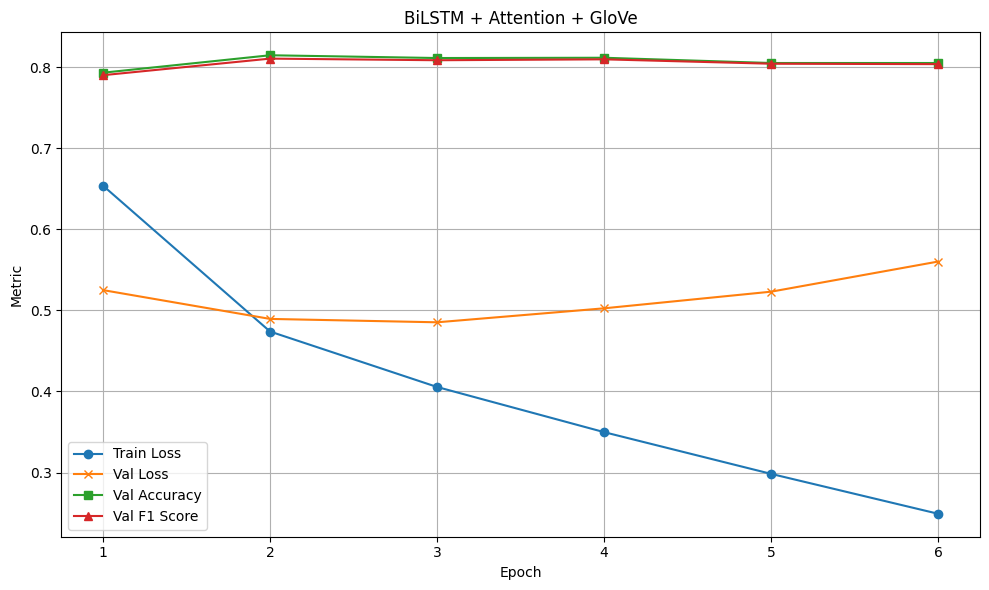

In [114]:
plot_history(intermediate_histories["BiLSTM + GloVe"], title="BiLSTM + Attention + GloVe")

## 3.6 Summary of Word Embedding Models

In this section, we evaluated multiple deep learning architectures using **pretrained word embeddings** — **GloVe (Twitter 200d)** and **FastText (Wiki-News 300d)** — to assess their effectiveness on tweet sentiment classification.

### Observations:

- **GloVe embeddings consistently outperformed FastText** across all model types (RNN, LSTM, BiLSTM, etc.). This is likely due to GloVe being trained on Twitter data, making it better suited to the informal, emoji- and hashtag-rich language of tweets.

- The **best overall performance** was achieved by:
  - `BiLSTM + GloVe`: **Accuracy = 0.8145**, **Weighted F1 = 0.8094**
  - `GRU + GloVe`: also performed very well, confirming the effectiveness of GloVe in sequential models.

- **FastText embeddings underperformed**, especially in simpler models like RNN or GRU. Although FastText handles rare words via subword units, its training on Wikipedia makes it less effective for social media data.

- **Vanilla RNN models** (both GloVe and FastText) showed the weakest performance, emphasizing the need for more expressive architectures like LSTM and BiLSTM.

---

## Conclusion

Pretrained word embeddings (especially **GloVe Twitter**) help improve performance over traditional one-hot representations. However, their capacity is still limited:

- They produce **static embeddings** (same vector regardless of context).
- They cannot capture **polysemy**, **sarcasm**, or long-range dependencies effectively.

---

## Next Step: Transformers and State-of-the-Art (SOTA) Models

To overcome these limitations and push performance further, we now move on to **transformer-based architectures** (e.g., **BERT**), which provide:

- **Contextual word embeddings**
- **Self-attention** to capture full-sequence information
- **Fine-tuning on downstream tasks** for better generalization

These models are expected to set a new performance benchmark on our sentiment classification task.


# 4. Transformers and State-of-the-Art Models

In this section, we transition from traditional word embeddings (GloVe, FastText) and recurrent models (RNNs, LSTMs, GRUs) to modern transformer-based architectures. Transformers have become the de facto standard in NLP due to their ability to model global context and produce dynamic, context-aware representations of language.

The goal of this part is to fine-tune pretrained transformer models on our tweet sentiment classification task and compare their performance to earlier models.

## 4.1 Tokenization, Formatting, and Dataset Splitting

Before fine-tuning transformer models, we must prepare the dataset in a format suitable for input into models such as BERT, RoBERTa, or DistilBERT. These models expect tokenized inputs that include:

- `input_ids`: token indices from the tokenizer's vocabulary;
- `attention_mask`: binary mask indicating which tokens should be attended to;

We use the `AutoTokenizer` from Hugging Face to ensure compatibility with each pretrained model. After tokenizing the dataset, we convert it into a PyTorch-ready format. Finally, we split the dataset into training and testing subsets for evaluation.

In [230]:
class TweetDataset(Dataset):
    def __init__(self, hf_dataset):
        self.input_ids = hf_dataset["input_ids"]
        self.attention_mask = hf_dataset["attention_mask"]
        self.labels = hf_dataset["label"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [138]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import Dataset
import torch

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
hf_dataset = Dataset.from_pandas(df_processed[["text", "label"]])
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
dataset_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = TweetDataset(dataset_split["train"])
test_dataset = TweetDataset(dataset_split["test"])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

## 4.2 Model Initialization

In this part, we define a reusable transformer-based classifier that we will use for all models (BERT, RoBERTa, DistilBERT, BERTweet).

We load a pretrained encoder using `AutoModel`, and manually add a dropout and linear classification head. This gives us full control over the architecture.

Depending on the model, we extract either the `pooler_output` or the `[CLS]` token representation from `last_hidden_state`.


In [139]:
from transformers import AutoModel
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes=3, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            x = outputs.pooler_output
        else:
            x = outputs.last_hidden_state[:, 0]

        x = self.dropout(x)
        return self.classifier(x)

## 4.3 Training Setup

To maintain consistency with earlier sections, we reuse our custom training pipeline instead of relying on Hugging Face's `Trainer`.

This gives us full control over:
- Optimizer (AdamW)
- Loss function (CrossEntropyLoss)
- Training loop logic
- Batch structure (input IDs, attention mask, labels)

We slightly adapt the training and evaluation functions to work with transformer-specific inputs.


In [140]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=2e-5, device='cuda', patience=3):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": []
    }

    best_f1 = 0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        print(f"\nTrain Loss: {train_loss:.4f}")
        history["train_loss"].append(train_loss)

        if val_loader is not None:
            val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, device)
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1"].append(val_f1)

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                print("Improvement found, saving model.")
            else:
                epochs_no_improve += 1
                print(f"EarlyStopping counter: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, history

In [141]:
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    model.to(device)
    y_true, y_pred = [], []
    total_loss = 0
    criterion = CrossEntropyLoss()

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    avg_loss = total_loss / len(data_loader)
    return avg_loss, acc, f1

In [142]:
def train_and_evaluate(name, model_name, train_loader, test_loader, num_classes=3, dropout=0.3, epochs=10, freeze=False):
    model = TransformerClassifier(model_name=model_name, num_classes=num_classes, dropout=dropout)
    model, history = train_model(model, train_loader, test_loader, num_epochs=epochs)

    _, acc, f1 = evaluate_model(model, test_loader)
    result = {"Accuracy": acc, "F1-Score": f1}

    print(f"\n{name} Results:\nAccuracy: {acc:.4f}, Weighted F1: {f1:.4f}")
    return name, result, history

## 4.4 Training Transformer Models

We now train and evaluate the selected transformer-based models using our custom training pipeline.

Each model is initialized using its corresponding pretrained weights and trained on the same dataset split and hyperparameters to ensure fairness.

Models:
- BERT (bert-base-uncased)
- RoBERTa (roberta-base)
- DistilBERT (distilbert-base-uncased)

Results are saved in a dictionary for comparison.


In [152]:
bert_results = {}
bert_histories = {}

In [146]:
# BERT
name, result, history = train_and_evaluate("BERT", "bert-base-uncased", train_loader, test_loader)
bert_results[name] = result
bert_histories[name] = history

Epoch 1/10: 100%|██████████| 183/183 [03:47<00:00,  1.24s/it]



Train Loss: 0.5713
Val Loss: 0.4073, Val Accuracy: 0.8378, Val F1: 0.8396
Improvement found, saving model.


Epoch 2/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.3412
Val Loss: 0.3987, Val Accuracy: 0.8473, Val F1: 0.8449
Improvement found, saving model.


Epoch 3/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.2418
Val Loss: 0.4176, Val Accuracy: 0.8525, Val F1: 0.8505
Improvement found, saving model.


Epoch 4/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.1604
Val Loss: 0.5088, Val Accuracy: 0.8460, Val F1: 0.8450
EarlyStopping counter: 1/3


Epoch 5/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.0998
Val Loss: 0.5657, Val Accuracy: 0.8436, Val F1: 0.8436
EarlyStopping counter: 2/3


Epoch 6/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.0776
Val Loss: 0.5881, Val Accuracy: 0.8494, Val F1: 0.8495
EarlyStopping counter: 3/3
Early stopping triggered.

BERT Results:
Accuracy: 0.8525, Weighted F1: 0.8505


In [147]:
# RoBERTa
name, result, history = train_and_evaluate("RoBERTa", "roberta-base", train_loader, test_loader)
bert_results[name] = result
bert_histories[name] = history

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 183/183 [03:47<00:00,  1.24s/it]



Train Loss: 0.7966
Val Loss: 0.6845, Val Accuracy: 0.7189, Val F1: 0.7199
Improvement found, saving model.


Epoch 2/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.6197
Val Loss: 0.5935, Val Accuracy: 0.7671, Val F1: 0.7530
Improvement found, saving model.


Epoch 3/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.5411
Val Loss: 0.5656, Val Accuracy: 0.7725, Val F1: 0.7666
Improvement found, saving model.


Epoch 4/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.4717
Val Loss: 0.5556, Val Accuracy: 0.7783, Val F1: 0.7770
Improvement found, saving model.


Epoch 5/10: 100%|██████████| 183/183 [03:47<00:00,  1.24s/it]



Train Loss: 0.4119
Val Loss: 0.6072, Val Accuracy: 0.7702, Val F1: 0.7764
EarlyStopping counter: 1/3


Epoch 6/10: 100%|██████████| 183/183 [03:47<00:00,  1.24s/it]



Train Loss: 0.3578
Val Loss: 0.5791, Val Accuracy: 0.7835, Val F1: 0.7770
EarlyStopping counter: 2/3


Epoch 7/10: 100%|██████████| 183/183 [03:46<00:00,  1.24s/it]



Train Loss: 0.3062
Val Loss: 0.5922, Val Accuracy: 0.7797, Val F1: 0.7761
EarlyStopping counter: 3/3
Early stopping triggered.

RoBERTa Results:
Accuracy: 0.7783, Weighted F1: 0.7770


In [151]:
# DistilBERT
name, result, history = train_and_evaluate("DistilBERT", "distilbert-base-uncased", train_loader, test_loader)
bert_results[name] = result
bert_histories[name] = history

Epoch 1/10: 100%|██████████| 183/183 [01:54<00:00,  1.60it/s]



Train Loss: 0.5288
Val Loss: 0.4276, Val Accuracy: 0.8303, Val F1: 0.8217
Improvement found, saving model.


Epoch 2/10: 100%|██████████| 183/183 [01:54<00:00,  1.60it/s]



Train Loss: 0.3592
Val Loss: 0.4154, Val Accuracy: 0.8453, Val F1: 0.8407
Improvement found, saving model.


Epoch 3/10: 100%|██████████| 183/183 [01:54<00:00,  1.61it/s]



Train Loss: 0.2676
Val Loss: 0.4285, Val Accuracy: 0.8395, Val F1: 0.8416
Improvement found, saving model.


Epoch 4/10: 100%|██████████| 183/183 [01:53<00:00,  1.61it/s]



Train Loss: 0.1839
Val Loss: 0.5049, Val Accuracy: 0.8426, Val F1: 0.8380
EarlyStopping counter: 1/3


Epoch 5/10: 100%|██████████| 183/183 [01:53<00:00,  1.61it/s]



Train Loss: 0.1214
Val Loss: 0.5723, Val Accuracy: 0.8422, Val F1: 0.8376
EarlyStopping counter: 2/3


Epoch 6/10: 100%|██████████| 183/183 [01:54<00:00,  1.61it/s]



Train Loss: 0.0865
Val Loss: 0.6300, Val Accuracy: 0.8320, Val F1: 0.8318
EarlyStopping counter: 3/3
Early stopping triggered.

DistilBERT Results:
Accuracy: 0.8395, Weighted F1: 0.8416


In [169]:
bert_final_results = pd.DataFrame.from_dict(bert_results, orient='index')
bert_final_results.index.name = 'Model'
bert_final_results.reset_index(inplace=True)

# Sorting by F1-Score
bert_final_results = bert_final_results.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
bert_final_results

,Model,Accuracy,F1-Score
0,BERT,0.8525,0.8505
1,DistilBERT,0.8395,0.8416
2,RoBERTa,0.7783,0.7770


## 4.5 Results on BERTs training

In this section, we fine-tuned multiple transformer models on the sentiment analysis task for tweets. The models tested include:

- **BERT (bert-base-uncased)**
- **DistilBERT (distilbert-base-uncased)**
- **RoBERTa (roberta-base)**

The models were trained and evaluated using the same preprocessed dataset, and the results were compared based on **accuracy** and **weighted F1-score**, which balances performance across different classes (negative, neutral, positive).

#### Key Observations:
- **BERT** achieved the highest performance, with an accuracy of 85.25% and a weighted F1-score of 85.05%. This indicates that BERT, despite being a larger model, provides a strong understanding of sentiment within the dataset.
- **DistilBERT**, a smaller version of BERT, performed similarly, with an accuracy of 83.95% and a weighted F1-score of 84.16%. This shows that even with fewer parameters, DistilBERT maintains competitive performance.
- **RoBERTa**, which is considered an optimized version of BERT, performed the lowest among the models tested, with an accuracy of 77.83% and a weighted F1-score of 77.70%. While still strong, RoBERTa does not surpass BERT on this task.


# 5. Conclusion

In this project, we evaluated multiple models and their performances using different feature extraction methods, including pre-trained embeddings and traditional techniques. The models were tested on a sentiment analysis task, with accuracy and F1-score being the key evaluation metrics.

### Key Findings:
1. **BERT** achieved the highest performance, with an accuracy of 85.25% and an F1-score of 85.05%, outperforming other models.
2. **DistilBERT** followed closely with an accuracy of 83.95% and an F1-score of 84.16%.
3. **BiLSTM + GloVe** and **GRU + GloVe** also performed well with F1-scores of 80.94% and 80.48%, respectively.
4. Among traditional models, **Logistic Regression** and **SVM** with **BoW** showed competitive results with accuracy values of 80.29% and 79.92%, respectively.
5. The lower-performing models, such as **RNN + GloVe** and **Naive Bayes**, demonstrated lower accuracy and F1-scores, especially with embeddings like FastText.

### Best Model:
The best performing model in our experiments was **BERT**, followed by **DistilBERT** and **BiLSTM + GloVe**. This suggests that transformer-based models, especially BERT, are highly effective for sentiment analysis tasks. The performance gains from using pre-trained embeddings like GloVe and FastText were notable but not as impactful as using transformers like BERT.

### Future Work:
Future experiments could focus on fine-tuning these transformer-based models with domain-specific data or exploring other advanced techniques like **transformer-based attention mechanisms** or **ensemble methods** to further improve model performance.

In [227]:
base_results = base_results.reset_index(drop=True)
best_results = pd.concat([base_results, intermediate_results, bert_final_results])
best_results = best_results.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
best_results

,Model,Accuracy,F1-Score
0,BERT,0.8525,0.8505
1,DistilBERT,0.8395,0.8416
2,BiLSTM + GloVe,0.8145,0.8094
3,BiLSTM + Attention + GloVe,0.8122,0.8063
4,GRU + GloVe,0.8094,0.8048
5,Logistic Regression + BoW,0.8029,0.7996
6,SVM + BoW,0.7992,0.7957
7,Logistic Regression + TF-IDF,0.7999,0.7948
8,SVM + TF-IDF,0.7985,0.7905
9,BiLSTM + FastText,0.7889,0.7891
